In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy import stats
import matplotlib.ticker as ticker
import os
from reload_recursive import reload_recursive
import patsy
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from statsmodels.miscmodels.ordinal_model import OrderedModel
from pingouin import mediation_analysis

from mri_data import file_manager as fm
import helpers

In [74]:
reload_recursive(helpers)

## Setup

In [20]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
showfigs = False
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.precision = 3

In [81]:
df = pd.read_csv(data_dir / "t1_data_full.csv")

In [83]:
df = pd.read_csv(data_dir / "t1_data_full.csv")
df = df.set_index("subid")

df = helpers.set_dz_type5(df)
df = helpers.set_dz_type3(df)
df = helpers.set_dz_type2(df)
df = helpers.fix_edss(df)
df = helpers.clean_df(df)
df = helpers.set_has_prl(df)

keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dz_type2",
    "dz_type3",
    "dz_type5",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "DMT_score",
    "DMT_hx_all",
    "flair_contrast",
    "thalamus",
    "brain",
    "white",
    "grey",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "HAS_PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume", 
    "pituitary_volume"
]

df = df.loc[:, keep_cols]
df = pd.concat((df, pd.get_dummies(df["sex"], dtype="int")), axis=1)
df["Intercept"] = 1

In [84]:
df.loc[:, "lesion_vol_logtrans"] = np.log(df["lesion_vol_cubic"])
df.loc[:, "edss_sqrt"] = np.sqrt(df["EDSS"].astype("float"))
df.loc[:, "msss_sqrt"] = np.sqrt(df["MSSS"])
df.loc[:, "armss_sqrt"] = np.sqrt(df["ARMSS"])
df.loc[:, "gmsss_sqrt"] = np.sqrt(df["gMSSS"])

In [85]:
vars = [
    "age",
    "Female",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "edss_sqrt",
    "msss_sqrt",
    "armss_sqrt",
    "gmsss_sqrt",
    "DMT_score",
    "DMT_hx_all",
    "thalamus",
    "brain",
    "white",
    "grey",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "HAS_PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume"
]

for var in vars:
    df[var] = pd.to_numeric(df[var])

In [86]:
vars_to_center = ["edss_sqrt", "lesion_vol_logtrans", "lesion_vol_cubic", "dzdur", "choroid_volume"]

for var in vars_to_center:
    df[f"{var}_cent"] = df[var] - df[var].mean()

centered_vars = [f"{var}_cent" for var in vars_to_center]
vars.extend(centered_vars)

In [87]:
vars_to_scale = [
    "age",
    "dzdur",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
]

df_scale = df.copy()
df_scale[vars_to_scale] = df_scale[vars_to_scale] / df_scale[vars_to_scale].mean()

In [88]:
df_ms = df.loc[df['dz_type2'] == "MS"]
df_scale_ms = df_scale.loc[df['dz_type2'] == "MS"]

df_z = df[vars].astype("float")
df_z[df.columns[~df.columns.isin(vars)]] = df[df.columns[~df.columns.isin(vars)]]
df_z = df_z[df.columns]
df_z[vars] = df_z[vars].apply(stats.zscore, nan_policy="omit")

data = df[vars].astype("float")
data_z = data[vars].apply(stats.zscore, nan_policy="omit")

data_ms = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
data_ms = data_ms[vars].astype("float")
data_ms_z = data_ms[vars].apply(stats.zscore, nan_policy="omit")

## Analysis

### Choroid Volumes

CP volume increased with age (β=0.38, p<0.001), TIV (β=0.16, p=0.001), and was smaller in females (β=-0.15, p=0.002), but was not associated with the presence of MS (β=0.18, p=0.10)

In [28]:
model_data = df_z[df_z['dz_type2'].isin(["MS", "!MS"])]
res = sm.OLS.from_formula(
    "choroid_volume ~ dz_type2 + age + tiv + Female", data=model_data
).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.236
R2_adj: 0.230
                 coef          p
Intercept      -0.150  1.434e-01
dz_type2[T.MS]  0.183  1.022e-01
age             0.385  1.688e-19
tiv             0.160  1.070e-03
Female         -0.153  1.849e-03


Within the population of MS patients, those with PMS had greater CP volumes than those with RMS, after controlling for age, sex, and TIV (β=0.36, p=0.003). 

In [29]:
model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("choroid_volume ~ dz_type5 + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.254
R2_adj: 0.246
                  coef          p
Intercept        0.315  3.054e-03
dz_type5[T.RMS] -0.359  3.329e-03
Female          -0.163  2.374e-03
age              0.321  8.375e-11
tiv              0.135  1.163e-02


In a multivariable regression controlling for age, sex, and TIV, CP volume increased with WM lesion volume (β=0.21, p<0.001) and number of PRL lesions (β=0.16, p<0.001). There was still a significant positive association with PMS (β=0.27. p=0.019)

In [30]:
model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("choroid_volume ~ lesion_vol_cubic + PRL + dz_type5 + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.334
R2_adj: 0.325
                   coef          p
Intercept         0.221  3.096e-02
dz_type5[T.RMS]  -0.274  1.941e-02
lesion_vol_cubic  0.212  4.608e-06
PRL               0.163  7.904e-05
Female           -0.166  1.138e-03
age               0.322  1.199e-10
tiv               0.109  3.141e-02


An ANCOVA was conducted to examine differences in CP volume amongst the RMS, PMS, OIND, and NIND groups, controlling for age, sex, and TIV. The analysis revealed a significant main effect for disease phenotype on CP volume (p < 0.001). Post hoc Tukey's HSD comparisons indicated that PMS had significantly larger CP than both NIND (p=0.043, d=0.51) and RMS (p=0.011, d=0.42). Additionally, sex (p<0.001), age (p<0.001), and TIV (p=0.006) were significant covariates. 

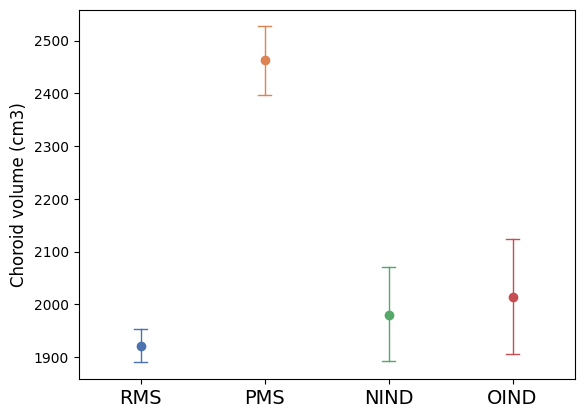

In [31]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS", "NIND", "OIND"])]

res = sm.OLS.from_formula("choroid_volume ~ dz_type5 + Female + age + tiv + lesion_vol_cubic + DMT_hx_all", data=model_data).fit()
# Extract marginal means (using 'Group')
marginal_means = res.predict(model_data[['Female', 'age', 'tiv', 'dz_type5', 'lesion_vol_cubic', 'DMT_hx_all']].drop_duplicates())

f = plt.figure()
ax = sns.pointplot(x='dz_type5', y=marginal_means, data=model_data, 
              palette='deep', hue='dz_type5', legend=False, markers='o', linestyles='-', color='red', 
              capsize=0.1, markersize=5, markeredgewidth=2, linewidth=1)
ax.set_ylabel("Choroid volume (cm3)", fontsize=12)
ax.set_xlabel("")
ax.set_xticks(["RMS", "PMS", "NIND", "OIND"])
ax.set_xticklabels(["RMS", "PMS", "NIND", "OIND"], fontsize=14)
f.patch.set_alpha(0)

Other correlations with choroid volume

In [124]:
model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]

res = sm.OLS.from_formula("choroid_volume ~ thalamus + Female + age + tiv", data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         choroid_volume   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     71.89
Date:                Tue, 04 Mar 2025   Prob (F-statistic):           4.94e-46
Time:                        15:59:53   Log-Likelihood:                -479.67
No. Observations:                 412   AIC:                             969.3
Df Residuals:                     407   BIC:                             989.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0101      0.039     -0.260      0.7

In [68]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS"])]

res = sm.OLS.from_formula("choroid_volume ~ EDSS + dzdur + dz_type5 + lesion_vol_cubic + PRL + Female + age + tiv", data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         choroid_volume   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     25.22
Date:                Tue, 04 Mar 2025   Prob (F-statistic):           2.92e-31
Time:                        13:45:40   Log-Likelihood:                -3052.9
No. Observations:                 395   AIC:                             6124.
Df Residuals:                     386   BIC:                             6160.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          542.9165    463.042  

The best performing regression model for predicting CP volume in MS patients had an R² of 0.36 (adj R²=0.35).

In [80]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS"])]

res = sm.OLS.from_formula("choroid_volume ~ MSSS + DMT_hx_all + dz_type5 + lesion_vol_cubic + PRL", data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         choroid_volume   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     22.29
Date:                Tue, 04 Mar 2025   Prob (F-statistic):           1.53e-19
Time:                        14:31:23   Log-Likelihood:                -2937.1
No. Observations:                 376   AIC:                             5886.
Df Residuals:                     370   BIC:                             5910.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1990.2942    130.039  

### PRL Count

Choroid predicts PRL count after controlling for age, sex, tiv, and lesion volume. Show the analysis

In [33]:
mediator_model = sm.GLM.from_formula("PRL ~ lesion_vol_cubic + age + Female + tiv + choroid_volume", data=df_scale_ms, family=sm.families.Poisson())
res = mediator_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    PRL   No. Observations:                  410
Model:                            GLM   Df Residuals:                      404
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -712.54
Date:                Tue, 04 Mar 2025   Deviance:                       995.12
Time:                        12:46:17   Pearson chi2:                 1.27e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4470
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.7724      0.714  

### Clinical Disability

In [90]:
model_data = df_z.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :]

There was a significant positive association between choroid volume and EDSS (β=0.10, p=0.043) 

In [35]:
model = sm.OLS.from_formula("edss_sqrt ~ choroid_volume + tiv + age + Female", data=model_data)
res = model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.225
R2_adj: 0.217
                 coef      p
Intercept       0.019  0.661
choroid_volume  0.101  0.043
tiv            -0.073  0.180
age             0.411  0.000
Female         -0.056  0.300


PRL count was positively associated with EDSS (β=0.11, p=0.01)

In [38]:
model = sm.OLS.from_formula("edss_sqrt ~ PRL + tiv + age + Female", data=model_data)
res = model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.229
R2_adj: 0.221
            coef      p
Intercept  0.007  0.884
PRL        0.106  0.013
tiv       -0.067  0.211
age        0.476  0.000
Female    -0.074  0.157


In [44]:
model = sm.OLS.from_formula("edss_sqrt ~ PRL + choroid_volume + tiv + age + Female", data=model_data)
res = model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.214
R2_adj: 0.203
                 coef      p
Intercept       0.981  0.021
PRL             0.027  0.031
choroid_volume  0.154  0.099
tiv            -0.449  0.221
age             0.896  0.000
Female         -0.066  0.390


In [39]:
model = sm.OLS.from_formula("edss_sqrt ~ choroid_volume + lesion_vol_cubic + PRL + tiv + age + Female", data=model_data)
res = model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.249
R2_adj: 0.237
                   coef      p
Intercept        -0.001  0.978
choroid_volume    0.036  0.490
lesion_vol_cubic  0.138  0.005
PRL               0.073  0.095
tiv              -0.072  0.178
age               0.416  0.000
Female           -0.069  0.194


Other associations

In [122]:
model = sm.OLS.from_formula("edss_sqrt ~ grey + choroid_volume + tiv + age + Female", data=model_data)
res = model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.228
R2_adj: 0.219
                 coef      p
Intercept       0.019  0.672
grey           -0.071  0.201
choroid_volume  0.083  0.110
tiv            -0.070  0.199
age             0.379  0.000
Female         -0.046  0.396


#### Mediation Analysis

##### Lesion volume mediating effect of CP volume on EDSS

In [47]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + lesion_vol_logtrans + age + tiv + Female", data=df_scale_ms
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ choroid_volume + age + tiv + Female", data=df_scale_ms
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "lesion_vol_logtrans"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.105,0.040,0.182,0.00
ACME (treated),0.105,0.040,0.182,0.00
ADE (control),0.068,-0.107,0.234,0.42
ADE (treated),0.068,-0.107,0.234,0.42
Total effect,0.173,0.006,0.325,0.04
Prop. mediated (control),0.582,0.081,4.606,0.04
Prop. mediated (treated),0.582,0.081,4.606,0.04
ACME (average),0.105,0.040,0.182,0.00
ADE (average),0.068,-0.107,0.234,0.42
Prop. mediated (average),0.582,0.081,4.606,0.04


In [123]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + thalamus + age + tiv + Female", data=df_scale_ms
)
mediator_model = sm.OLS.from_formula(
    "thalamus ~ choroid_volume + age + tiv + Female", data=df_scale_ms
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "thalamus"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.230,0.129,0.344,0.000
ACME (treated),0.230,0.129,0.344,0.000
ADE (control),-0.053,-0.262,0.152,0.630
ADE (treated),-0.053,-0.262,0.152,0.630
Total effect,0.176,-0.004,0.360,0.056
Prop. mediated (control),1.222,-3.129,7.491,0.056
Prop. mediated (treated),1.222,-3.129,7.491,0.056
ACME (average),0.230,0.129,0.344,0.000
ADE (average),-0.053,-0.262,0.152,0.630
Prop. mediated (average),1.222,-3.129,7.491,0.056


In [101]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ lesion_vol_cubic + thalamus + age + tiv + Female", data=df_scale_ms
)
mediator_model = sm.OLS.from_formula(
    "thalamus ~ lesion_vol_cubic + age + tiv + Female", data=df_scale_ms
)

med = Mediation(
    outcome_model, mediator_model, "lesion_vol_cubic", "thalamus"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.104,0.046,0.169,0.000
ACME (treated),0.104,0.046,0.169,0.000
ADE (control),0.069,-0.032,0.200,0.206
ADE (treated),0.069,-0.032,0.200,0.206
Total effect,0.172,0.075,0.293,0.000
Prop. mediated (control),0.614,0.238,1.404,0.000
Prop. mediated (treated),0.614,0.238,1.404,0.000
ACME (average),0.104,0.046,0.169,0.000
ADE (average),0.069,-0.032,0.200,0.206
Prop. mediated (average),0.614,0.238,1.404,0.000


In [48]:
model_data = df_scale_ms.dropna()
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + PRL + age + tiv + Female", data=model_data
)
mediator_model = sm.GLM.from_formula(
    "PRL ~ choroid_volume + age + tiv + Female", data=model_data, family=sm.families.Poisson()
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "PRL"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.023,0.004,0.047,0.014
ACME (treated),0.023,0.004,0.047,0.014
ADE (control),0.153,-0.035,0.317,0.114
ADE (treated),0.153,-0.035,0.317,0.114
Total effect,0.176,-0.009,0.340,0.068
Prop. mediated (control),0.117,-0.627,0.925,0.082
Prop. mediated (treated),0.117,-0.627,0.925,0.082
ACME (average),0.023,0.004,0.047,0.014
ADE (average),0.153,-0.035,0.317,0.114
Prop. mediated (average),0.117,-0.627,0.925,0.082


Lesion volume mediating effect of PRL count on EDSS. There is a significant effect, but don't think it describes anything interesting (ie more PRL mean greater lesion volume which is related to EDSS)

In [49]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ PRL + lesion_vol_logtrans + age + tiv + Female", data=df_scale_ms
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ PRL + age + tiv + Female", data=df_scale_ms
)

med = Mediation(
    outcome_model, mediator_model, "PRL", "lesion_vol_logtrans"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.011,-9.843e-04,0.027,0.084
ACME (treated),0.011,-9.843e-04,0.027,0.084
ADE (control),0.019,-1.710e-03,0.042,0.074
ADE (treated),0.019,-1.710e-03,0.042,0.074
Total effect,0.030,6.987e-03,0.054,0.008
Prop. mediated (control),0.366,-1.114e-01,1.123,0.092
Prop. mediated (treated),0.366,-1.114e-01,1.123,0.092
ACME (average),0.011,-9.843e-04,0.027,0.084
ADE (average),0.019,-1.710e-03,0.042,0.074
Prop. mediated (average),0.366,-1.114e-01,1.123,0.092


Significant effect, but same interpretation as above

In [42]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ lesion_count + lesion_vol_logtrans + age + tiv + Female", data=df_scale_ms
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ lesion_count + age + tiv + Female", data=df_scale_ms
)

med = Mediation(
    outcome_model, mediator_model, "lesion_count", "lesion_vol_logtrans"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.082,0.040,0.126,0.00
ACME (treated),0.082,0.040,0.126,0.00
ADE (control),-0.044,-0.101,0.008,0.11
ADE (treated),-0.044,-0.101,0.008,0.11
Total effect,0.038,-0.007,0.084,0.09
Prop. mediated (control),2.030,-7.752,15.064,0.09
Prop. mediated (treated),2.030,-7.752,15.064,0.09
ACME (average),0.082,0.040,0.126,0.00
ADE (average),-0.044,-0.101,0.008,0.11
Prop. mediated (average),2.030,-7.752,15.064,0.09


In [135]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ lesion_vol_logtrans + choroid_volume + thalamus + age + tiv + Female", data=df_scale_ms
)
mediator_model = sm.OLS.from_formula(
    "thalamus ~ choroid_volume + lesion_vol_logtrans + age + tiv + Female", data=df_scale_ms
)

med = Mediation(
    outcome_model, mediator_model, "lesion_vol_logtrans", "thalamus"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.041,0.016,0.069,0.000
ACME (treated),0.041,0.016,0.069,0.000
ADE (control),0.040,-0.008,0.092,0.104
ADE (treated),0.040,-0.008,0.092,0.104
Total effect,0.081,0.034,0.127,0.000
Prop. mediated (control),0.505,0.194,1.159,0.000
Prop. mediated (treated),0.505,0.194,1.159,0.000
ACME (average),0.041,0.016,0.069,0.000
ADE (average),0.040,-0.008,0.092,0.104
Prop. mediated (average),0.505,0.194,1.159,0.000


In [43]:
model_data = df_scale_ms.dropna()
outcome_model = sm.OLS.from_formula("edss_sqrt ~ lesion_count + PRL + age + Female + tiv", data=model_data)
# print(outcome_model.fit().summary())

mediator_model = sm.GLM.from_formula("PRL ~ lesion_count + age + Female + tiv", data=model_data, family=sm.families.Poisson())
# print(mediator_model.fit().summary())

med = Mediation(
    outcome_model, mediator_model, "lesion_count", "PRL"
).fit()
print(med.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)               0.004      -9.071e-04           0.011    0.116
ACME (treated)               0.004      -9.071e-04           0.011    0.116
ADE (control)                0.042       1.933e-03           0.085    0.044
ADE (treated)                0.042       1.933e-03           0.085    0.044
Total effect                 0.046       6.342e-03           0.089    0.022
Prop. mediated (control)     0.077      -4.396e-02           0.507    0.134
Prop. mediated (treated)     0.077      -4.396e-02           0.507    0.134
ACME (average)               0.004      -9.071e-04           0.011    0.114
ADE (average)                0.042       1.933e-03           0.085    0.044
Prop. mediated (average)     0.077      -4.396e-02           0.507    0.132


#### Moderation 

In [69]:
model_data = df_z.copy()
model_data = model_data[model_data['dz_type2'] == "MS"]

In [77]:
moderation_model = sm.OLS.from_formula("edss_sqrt ~ dzdur*lesion_vol_logtrans + tiv + age + Female", data=model_data)
res = moderation_model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.282
R2_adj: 0.27
                            coef      p
Intercept                 -0.036  0.433
dzdur                      0.165  0.005
lesion_vol_logtrans        0.157  0.001
dzdur:lesion_vol_logtrans  0.104  0.021
tiv                       -0.072  0.169
age                        0.272  0.000
Female                    -0.089  0.082


-0.8879458179902774


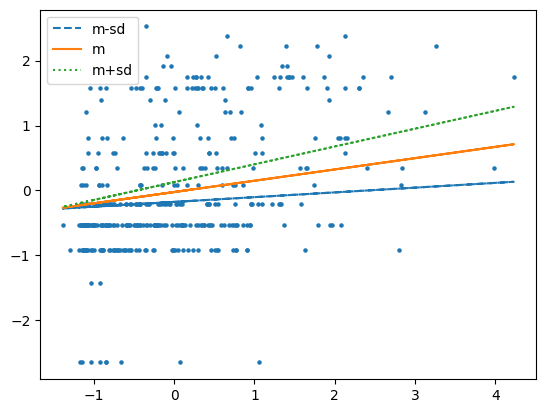

In [78]:
y_lvls = helpers.moderation_y(model_data, res.params, "dzdur", "lesion_vol_logtrans")
helpers.plot_moderation(model_data['dzdur'], model_data['edss_sqrt'], y_lvls)

In [71]:
model = sm.OLS.from_formula("edss_sqrt ~ dzdur*choroid_volume + tiv + age + Female", data=model_data)
res = model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.257
R2_adj: 0.246
                       coef      p
Intercept             0.011  0.809
dzdur                 0.228  0.000
choroid_volume        0.076  0.125
dzdur:choroid_volume  0.001  0.978
tiv                  -0.068  0.204
age                   0.275  0.000
Female               -0.077  0.145


#### Ordinal Regression on EDSS

In [124]:
model_data = df_scale.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :].dropna()

mod_prob = OrderedModel.from_formula("EDSS ~ PRL + tiv + age + Female",
                                     data=model_data, distr='logit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 2.190125
         Iterations: 77
         Function evaluations: 79
         Gradient evaluations: 79


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   EDSS   Log-Likelihood:                -812.54
Model:                   OrderedModel   AIC:                             1667.
Method:            Maximum Likelihood   BIC:                             1749.
Date:                Fri, 28 Feb 2025                                         
Time:                        15:51:02                                         
No. Observations:                 371                                         
Df Residuals:                     350                                         
Df Model:                           4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PRL            0.1034      0.042      2.474      0.013       0.021       0.185
tiv           -1.3265      1.296     -1.024      0.306      -3.867       1.214
age            3.4101      0.397      8.590      0.000       2.632       4.188
Female        -0.2848      0.266     -1.069      0.285      -0.807       0.237
0.0/1.0       -2.4345      1.547     -1.574      0.116      -5.467       0.598
1.0/1.5        0.9753      0.151      6.446      0.000       0.679       1.272
1.5/2.0        0.3874      0.094      4.140      0.000       0.204       0.571
2.0/2.5       -0.3045      0.124     -2.454      0.014      -0.548      -0.061
2.5/3.0       -1.3054      0.218     -5.997      0.000      -1.732      -0.879
3.0/3.5       -1.1684      0.207     -5.648      0.000      -1.574      -0.763
3.5/4.0       -1.2278      0.223     -5.499      0.000      -1.665      -0.790
4.0/4.5       -1.2832      0.244     -5.261      0.000      -1.761      -0.805
4.5/5.0       -2.5982      0.497     -5.232      0.000      -3.572      -1.625
5.0/5.5       -1.9922      0.374     -5.332      0.000      -2.725      -1.260
5.5/6.0       -2.4942      0.497     -5.022      0.000      -3.468      -1.521
6.0/6.5       -0.2007      0.176     -1.138      0.255      -0.546       0.145
6.5/7.0        0.0030      0.228      0.013      0.990      -0.444       0.450
7.0/7.5       -0.9465      0.498     -1.899      0.058      -1.923       0.030
7.5/8.0       -0.8638      0.577     -1.497      0.135      -1.995       0.267
8.0/8.5       -0.3410      0.584     -0.584      0.560      -1.487       0.804
8.5/9.0        0.1048      0.740      0.142      0.887      -1.345       1.554
==============================================================================
"""

#### MSSS

In [20]:
model = sm.OLS.from_formula("msss_sqrt ~ tiv + Female + lesion_vol_cubic + choroid_volume", data=df_scale)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              msss_sqrt   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.268
Date:                Sat, 22 Feb 2025   Prob (F-statistic):             0.0613
Time:                        16:36:36   Log-Likelihood:                -417.23
No. Observations:                 403   AIC:                             844.5
Df Residuals:                     398   BIC:                             864.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.5095      0.522  

#### ARMSS

In [21]:
model = sm.OLS.from_formula("armss_sqrt ~ choroid_volume + tiv + Female + age", data=df_scale)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             armss_sqrt   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.939
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           3.49e-06
Time:                        16:36:50   Log-Likelihood:                -412.59
No. Observations:                 440   AIC:                             835.2
Df Residuals:                     435   BIC:                             855.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0896      0.480      6.

### Mediation

In [20]:
p2 = Process(data=data_ms_z, model=3, x="choroid_volume", y="edss_sqrt", w="dzdur",
            m=["lesion_vol_logtrans"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 3

Variables:
    Cons = Cons
    x = choroid_volume
    y = edss_sqrt
    w = dzdur
    m = lesion_vol_logtrans
Statistical Controls:
 age, Female, tiv



Sample size:
412

***************************** OUTCOME MODELS ****************************

Outcome = edss_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2929   0.2727 0.7273 15.9886   10  386   0.0000

Coefficients

                                           coeff     se       t      p    LLCI   ULCI
Cons                                     -0.0685 0.0478 -1.4335 0.1525 -0.1621 0.0251
choroid_volume                            0.0038 0.0560  0.0683 0.9456 -0.1060 0.1136
lesion_vol_logtrans                       0.1401 0.0501  2.7947 0.0055  0.0418 0.2384
dzdur                                     0.1875 0.0591

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


In [75]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + lesion_vol_logtrans + age + tiv + Female", data=df_scale
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ choroid_volume + age + tiv + Female", data=df_scale
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "lesion_vol_logtrans"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.106996,0.054724,0.174995,0.000
ACME (treated),0.106996,0.054724,0.174995,0.000
ADE (control),0.067991,-0.102547,0.219749,0.426
ADE (treated),0.067991,-0.102547,0.219749,0.426
Total effect,0.174987,0.011623,0.331057,0.036
Prop. mediated (control),0.588430,0.193524,2.957493,0.036
Prop. mediated (treated),0.588430,0.193524,2.957493,0.036
ACME (average),0.106996,0.054724,0.174995,0.000
ADE (average),0.067991,-0.102547,0.219749,0.426
Prop. mediated (average),0.588430,0.193524,2.957493,0.036


PRL does not mediate the association between lesion count and EDSS

In [74]:
model_data = df_scale_ms.dropna()
outcome_model = sm.OLS.from_formula("edss_sqrt ~ lesion_count + PRL + age + Female + tiv", data=model_data)
# print(outcome_model.fit().summary())

mediator_model = sm.GLM.from_formula("PRL ~ lesion_count + age + Female + tiv", data=model_data, family=sm.families.Poisson())
# print(mediator_model.fit().summary())

med = Mediation(
    outcome_model, mediator_model, "lesion_count", "PRL"
).fit()
print(med.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.003839       -0.000646        0.010799    0.120
ACME (treated)            0.003839       -0.000646        0.010799    0.116
ADE (control)             0.042244        0.001254        0.083481    0.042
ADE (treated)             0.042244        0.001254        0.083481    0.042
Total effect              0.046083        0.005338        0.087924    0.030
Prop. mediated (control)  0.076149       -0.048580        0.438222    0.150
Prop. mediated (treated)  0.076149       -0.048580        0.438222    0.146
ACME (average)            0.003839       -0.000646        0.010799    0.120
ADE (average)             0.042244        0.001254        0.083481    0.042
Prop. mediated (average)  0.076149       -0.048580        0.438222    0.150


In [161]:
model_data = df_scale.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :].dropna()
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'])), axis=1
)
model_data['PMS'] = model_data['PMS'].astype("int64")

model = sm.GLM.from_formula("PRL ~ PMS + age + Female", data=model_data, family=sm.families.Poisson())
res = model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    PRL   No. Observations:                  371
Model:                            GLM   Df Residuals:                      367
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -677.32
Date:                Sat, 01 Mar 2025   Deviance:                       975.59
Time:                        16:05:21   Pearson chi2:                 1.40e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2707
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4501      0.216     11.368      0.0

### Predicting MS Phenotype

Logistic regression on PMS

In [160]:
model_data = df_z.loc[df_z['dz_type5'].isin(['RMS', 'PMS'])]
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'])), axis=1
)
model_data['PMS'] = model_data['PMS'].astype("int64")

# logit_mod = sm.Logit.from_formula("PMS ~ choroid_volume + lesion_vol_cubic + dzdur + age + tiv + Female", data=model_data)
logit_mod = sm.Logit.from_formula("PMS ~ PRL + age + tiv + Female", data=model_data)
res = logit_mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.379418
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    PMS   No. Observations:                  410
Model:                          Logit   Df Residuals:                      405
Method:                           MLE   Df Model:                            4
Date:                Fri, 28 Feb 2025   Pseudo R-squ.:                  0.2518
Time:                        16:07:18   Log-Likelihood:                -155.56
converged:                       True   LL-Null:                       -207.91
Covariance Type:            nonrobust   LLR p-value:                 9.854e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9558      0.190    -10.310      0.000      -2.328      -1.584
PRL            0.1270      0.

In [84]:
model_data = df_z.loc[df_z['dz_type2'].isin(['MS', '!MS'])]
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type2'])), axis=1
)
model_data['MS'] = model_data['MS'].astype("int64")

# logit_mod = sm.Logit.from_formula("PMS ~ choroid_volume + lesion_vol_cubic + dzdur + age + tiv + Female", data=model_data)
logit_mod = sm.Logit.from_formula("MS ~ choroid_volume + age + tiv + Female", data=model_data)
res = logit_mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.416241
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                     MS   No. Observations:                  487
Model:                          Logit   Df Residuals:                      482
Method:                           MLE   Df Model:                            4
Date:                Thu, 27 Feb 2025   Pseudo R-squ.:                 0.03108
Time:                        14:16:44   Log-Likelihood:                -202.71
converged:                       True   LL-Null:                       -209.21
Covariance Type:            nonrobust   LLR p-value:                   0.01126
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.7739      0.133     13.305      0.000       1.513       2.035
choroid_volume   

In [88]:
df.loc[df["dz_type5"]=="OIND", "dzdur"].mean()

8.653913845857144